In [235]:
# Load data set and target values
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass

from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd



p= Preprocessdata.standardprocess()


save_path = '/home/peng/Documents/Project_C/Turbofan/Dataset/'

results_path = '/home/peng/git/Machine_learning_for_reliability_analysis/RA_Risk/results/'
#names = xrange(0,28)

df = pd.read_csv(save_path + 'train_FD001_3_p20_.txt', header=0)

#df = pd.read_csv(save_path + 'train_FD001_2_disc.txt', header=0)
#df = df.sample(n=10000)
rad_stat = 2
seed = 'rf'

# drop the first column
df = df.drop(df.columns[[0]], axis=1)

#print (df)

#### scale the training dataset first and then apply the rules to test set 
#train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.7)
train, trainlabel, test, testlabel = p.scaledivd(df, 1.0)
#print (test[0:10])
test = train
testlabel = trainlabel*2

#print (testlabel[0:10])

In [227]:
# Variational autoencoder

'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
import timeit


start = timeit.default_timer()

#batch_size = 100
original_dim = 24
latent_dim = 2
intermediate_dim = 212
nb_epoch = 15

x = Input(shape=(24,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.fit(train, train,
        shuffle=True,
        nb_epoch=nb_epoch,
        #batch_size=batch_size,
        verbose = 0)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space

train_encoded = encoder.predict(train)
#print(np.shape(train)[1])
test_encoded = encoder.predict(test)
#print(np.shape(test))

encoded_dim = np.shape(train_encoded)[1]

stop = timeit.default_timer()

print ("The running takes %r min" %((stop-start)/60))

The running takes 0.09932966629664103 min


In [236]:
# Variational autoencoder  load the weights
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
import timeit


start = timeit.default_timer()

#batch_size = 100
original_dim = 24
latent_dim = 2
intermediate_dim = 12
nb_epoch = 15

x = Input(shape=(24,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.load_weights(results_path + 'model_vae3.h5')
vae.compile(optimizer='rmsprop', loss=vae_loss)

encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space

train_encoded = encoder.predict(train)
#print(np.shape(train)[1])
test_encoded = encoder.predict(test)
#print(np.shape(test))

encoded_dim = np.shape(train_encoded)[1]

stop = timeit.default_timer()

print ("The running takes %r min" %((stop-start)/60))

The running takes 0.003024450937906901 min


In [230]:
def read_model(name):
    latent_dim =2
    with open(results_path + name + '.json', "r") as jfile:
        target_model = model_from_json(json.load(jfile))
    target_model.load_weights(results_path + name +'.h5')
    target_model.compile(optimizer='rmsprop', loss=vae_loss)
    jfile.close()
    return target_model

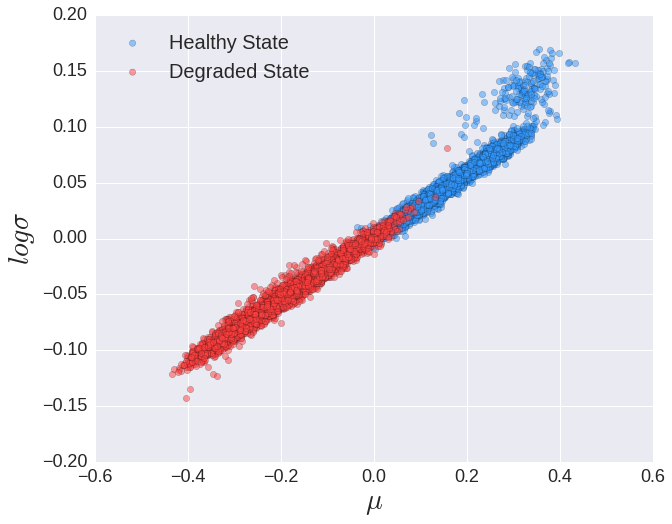

In [237]:
df_label = pd.DataFrame({'mean': test_encoded[:,0], 'std': test_encoded[:, 1], 'label': testlabel})

#print (df_label)
import seaborn as sns
from pylab import *

plt.figure(figsize=(10, 8), dpi=1200)

plt.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 40)

#plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'],
 #           c= '#6dc066', alpha=0.5, label = 'Degrading State', s = 40)

plt.scatter(df_label[df_label['label']==2]['mean'], df_label[df_label['label']==2]['std'],
            c= '#ff4040', alpha=0.5, label = 'Degraded State', s = 40)



plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.legend(fontsize = 20, loc=2)
#savefig(results_path + 'vae_2_v1.eps',dpi=1200)
plt.show()

In [172]:
from keras.models import model_from_json
import json

vae.save_weights(results_path + 'model_vae3.h5', overwrite=True)
with open(results_path  + "model_vae3.json", "w") as outfile:
    json.dump(vae.to_json(), outfile)
outfile.close()

In [196]:
df_label.to_csv(results_path+'vae_3_v2.csv', header = True)

In [244]:
#kmm the two labels

#df_label = pd.read_csv(results_path + 'vae_3_v2.csv', header = 0)
#df_label = df_label.drop(df.columns[[0]], axis=1)
df_new = pd.DataFrame()
df_new['mean']=df_label['mean']
df_new['std']=df_label['std']
df_new['label']=df_label['label']

df_new_2 = df_new[df_new['label']!=1]
df_new_3 = df_new_2.drop('label', 1)
train_kmm = np.array(df_new_3)
from sklearn.cluster import KMeans

n_num = 2

k_means = KMeans(init='k-means++', n_clusters=n_num, n_init=10)
X = train_kmm
k_means.fit(train_kmm)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import adjusted_mutual_info_score as ari

#print (confusion_matrix(k_means_labels,df_new_2['label']))
#print( classification_report(k_means_labels, df_new_2['label']))
#print (accuracy_score(k_means_labels,df_new_2['label']))

print (ari(k_means_labels, df_new_2['label']))

0.813032354323


In [239]:
#kmm the three labels

#df_label = pd.read_csv(results_path + 'vae_3_v2.csv', header = 0)
#df_label = df_label.drop(df.columns[[0]], axis=1)
df_new = pd.DataFrame()
df_new['mean']=df_label['mean']
df_new['std']=df_label['std']


train_kmm = np.array(df_new)
from sklearn.cluster import KMeans

n_num = 3

k_means = KMeans(init='k-means++', n_clusters=n_num, n_init=10)
X = train_kmm
k_means.fit(train_kmm)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)


from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import adjusted_mutual_info_score as ari

print (confusion_matrix(k_means_labels,testlabel))
print( classification_report(k_means_labels, testlabel))
print (accuracy_score(k_means_labels,testlabel))

print (ari(k_means_labels, testlabel))

[[2572 1757    2]
 [   0   17 3390]
 [1514 2448  871]]
             precision    recall  f1-score   support

          0       0.63      0.59      0.61      4331
          1       0.00      0.00      0.00      3407
          2       0.20      0.18      0.19      4833

avg / total       0.30      0.28      0.29     12571

0.275236655795
0.423257677173


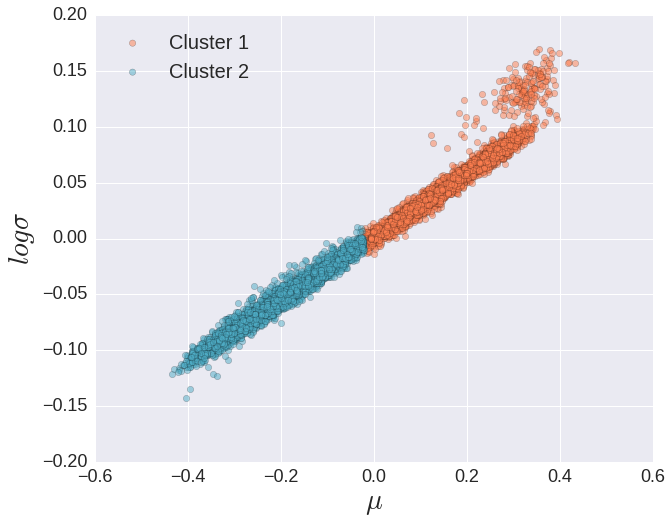

In [246]:
import seaborn as sns
from pylab import *

plt.figure(figsize=(10, 8), dpi=1200)
n_clusters = 2
colors = ['#ff7f50', '#4EACC5']
#colors = ['#ff7f50', '#4EACC5','#c0c0c0']
col_center = ['r', 'b']

# KMeans

for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    #plt.plot(X[my_members, 0], X[my_members, 1], 
             #'w', markerfacecolor=col, marker='.', alpha =0.5, markersize=13
            # label = 'Cluster %r' %(k+1))
    plt.scatter(X[my_members, 0], X[my_members, 1],  c = col, alpha =0.5, s =40, 
            label = 'Cluster %r' %(k+1))
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor= '#ff7f50', markeredgecolor='#000000', 
             #markersize=10)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.legend(fontsize = 20, loc=2)

savefig(results_path + 'vae_kmm_2_v1.eps',dpi=1200)
plt.show()


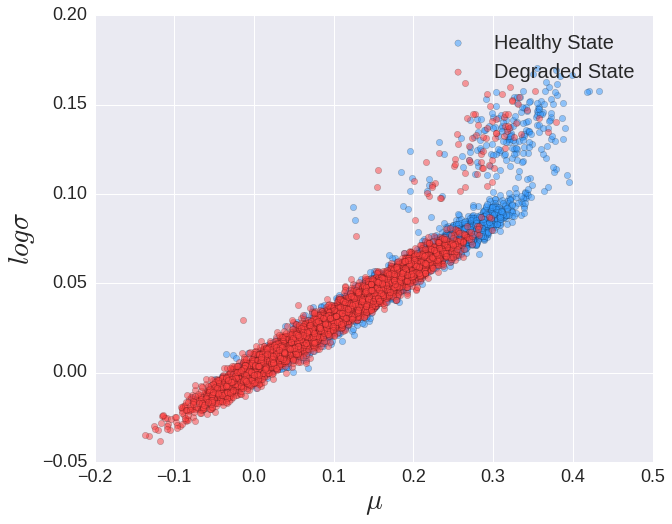

In [240]:
import seaborn as sns
from pylab import *

plt.figure(figsize=(10, 8), dpi=1200)

plt.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 40)
#plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'], c= 'y', alpha=0.5)

plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'],
            c= '#ff4040', alpha=0.5, label = 'Degraded State', s = 40)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.legend(fontsize = 20)
savefig(results_path + 'exercice_2.eps',dpi=1200)
plt.show()